# The effictiviness of measures to combat cellphone robery in the City of São Paulo

In [32]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Importing the data

In [2]:
stolen_cellphones_df = pd.read_pickle("Stollen_cell.pkl")

## Data treatment

- Using the data description as support we can beging to filter ours columns. First we will identify the columns where we have less than half of non-NaN values, those will not be used, this could happend because of a change in the metodology in the collection of the report.
- We will also be droping where the columns about where the BO was registred, since the police that collected the BO is not responsible for investigating, only the precinct of the area that the crime happened. 
- We can also filter some variable that are identical in all of the observations. Like in the variable `DESCR_MODO_OBJETO`, where all the observation say that the object was stollen. The same thing happens in `DESCR_TIPO_OBJETO`,`DESCR_SUBTIPO_OBJETO`.
- Then we can filter all other observations that are not from São Paulo
- We can join the columns `DATA_OCORRENCIA_BO` and `HORA_OCORRENCIA` to get the precise time at which the crime happened, that also means we can drop the `MES` and `ANO` columns.

In [3]:
navalue_count = stolen_cellphones_df.notna().sum()
columns_to_drop = list(navalue_count[navalue_count < stolen_cellphones_df.shape[0]/2].index)
columns_to_drop

['TIPO_INTOLERANCIA',
 'DESDOBRAMENTO',
 'CIRCUNSTANCIA',
 'VERSAO',
 'FLAG_ATO_INFRACIONAL',
 'LOGRADOURO_VERSAO',
 'FLAG_BLOQUEIO',
 'FLAG_DESBLOQUEIO']

In [4]:
columns_BO_register = ['ID_DELEGACIA', 'NOME_DEPARTAMENTO', 'NOME_SECCIONAL', 
                       'NOME_DELEGACIA', 'NOME_MUNICIPIO', 'ANO_BO', 'NUM_BO', 
                       'DATAHORA_REGISTRO_BO', 'DATA_COMUNICACAO_BO', 'DATAHORA_IMPRESSAO_BO']
columns_redundant = ['DESCR_MODO_OBJETO', 'DESCR_TIPO_OBJETO', 'DESCR_SUBTIPO_OBJETO']
columns_to_drop += columns_BO_register + columns_redundant

In [5]:
stolen_cellphones_filtered = stolen_cellphones_df.drop(columns_to_drop, axis=1)
stolen_cellphones_filtered["CIDADE"] = stolen_cellphones_filtered["CIDADE"].str.strip()
stolen_cellphones_filtered = stolen_cellphones_filtered[stolen_cellphones_filtered["CIDADE"] == "S.PAULO"] 

In [6]:
#stolen_cellphones_filtered[['DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA']]
import re
tmp = []
for _, date in stolen_cellphones_filtered[['DATA_OCORRENCIA_BO', 'HORA_OCORRENCIA']].iterrows():
    try:
        date_str = re.search(r'\d{4}-\d{2}-\d{2}', str(date['DATA_OCORRENCIA_BO'])).group()
    except AttributeError:
        tmp.append("9999-99-99")
        continue
    try:
        hour = re.search(r'\d{2}:\d{2}:\d{2}', str(date['HORA_OCORRENCIA'])).group()
        tmp.append(date_str + ' ' + hour)
    except:
        tmp.append(date_str + ' ' + '00:00:00')
        continue

In [7]:
stolen_cellphones_filtered['DATA_OCORRENCIA'] = tmp
stolen_cellphones_filtered = stolen_cellphones_filtered[(stolen_cellphones_filtered['DATA_OCORRENCIA'] >= "2017") & (stolen_cellphones_filtered['DATA_OCORRENCIA'] < "2024")]
stolen_cellphones_filtered['DATA_OCORRENCIA'] = pd.to_datetime(stolen_cellphones_filtered['DATA_OCORRENCIA'], format="%Y-%m-%d %H:%M:%S", errors="coerce")
stolen_cellphones_filtered.reset_index(inplace=True)

## EDA (Exploratory Data Analysis)

1. The first thing we are gonna explore is the frequency across time and places which the crimes are happening and try to identify patterns

Text(0.5, 0, 'Year of the occurence')

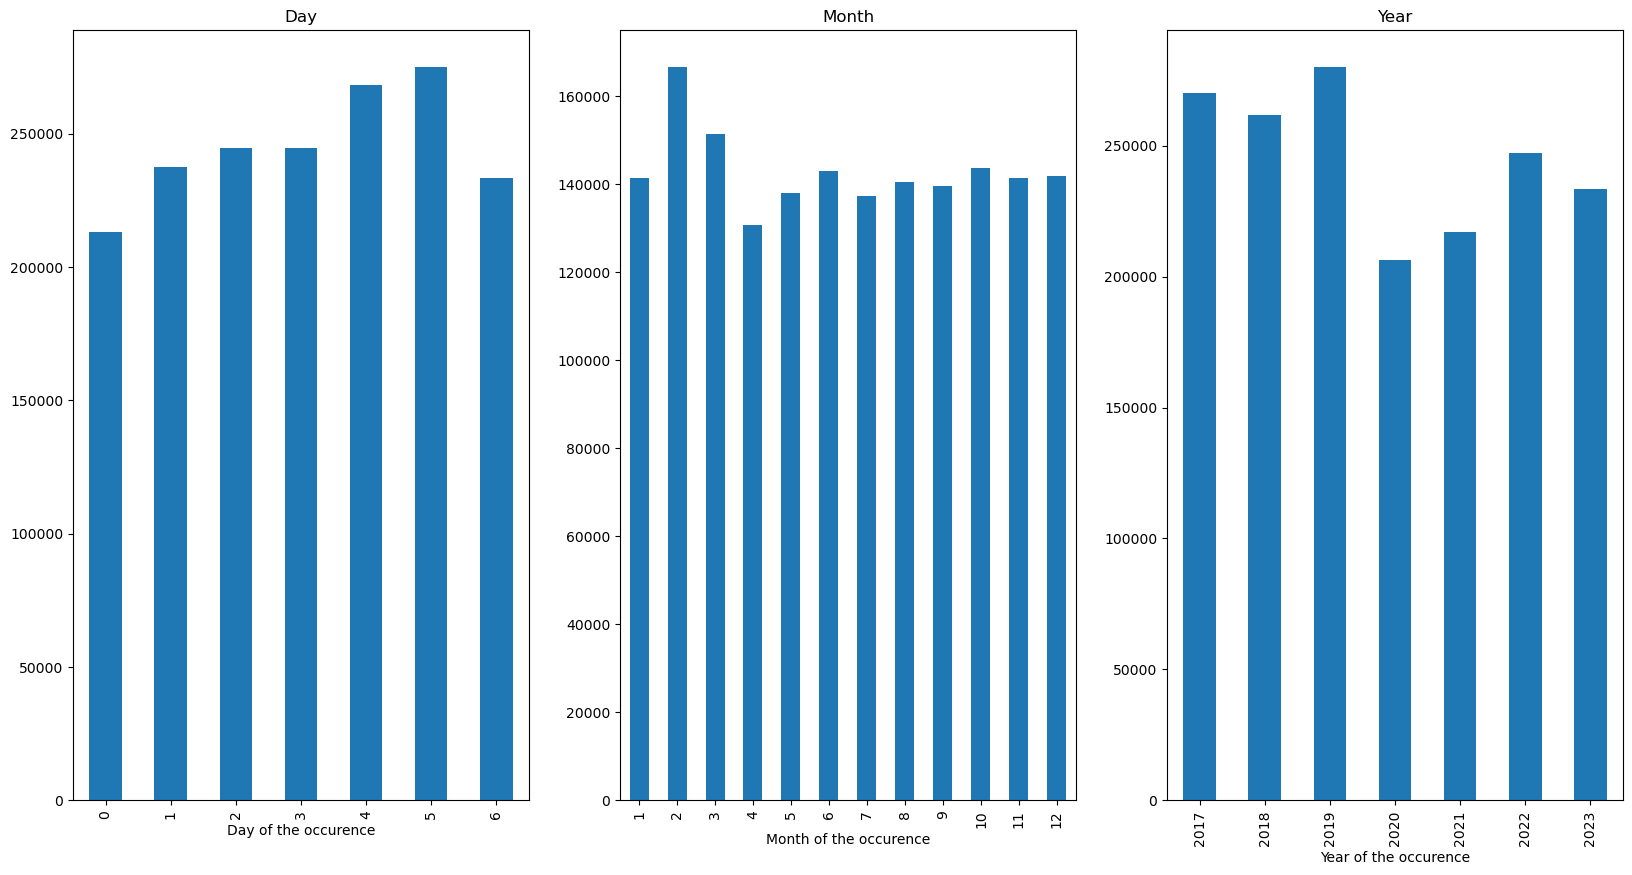

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(20,10))
stolen_cellphones_filtered.groupby(stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.weekday).size().plot.bar(ax=ax[0])
stolen_cellphones_filtered.groupby(stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.month).size().plot.bar(ax=ax[1])
stolen_cellphones_filtered.groupby(stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.year).size().plot.bar(ax=ax[2])
ax[0].set_title("Day")
ax[0].set_xlabel("Day of the occurence")
ax[1].set_title("Month")
ax[1].set_xlabel("Month of the occurence")
ax[2].set_title("Year")
ax[2].set_xlabel("Year of the occurence")

In [49]:
def plot_neighborhoods_per_year(year):
    rank = stolen_cellphones_filtered[stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.year == year].groupby("BAIRRO").size().sort_values(ascending=False)
    ax.clear()
    rank.head(15).plot.barh(ax=ax)
    ax.invert_yaxis()
    

In [50]:
fig, ax = plt.subplots(figsize=(7, 10))
years = stolen_cellphones_filtered["DATA_OCORRENCIA"].dt.year.unique()
years.sort()
animation = FuncAnimation(fig, plot_neighborhoods_per_year, frames=years, interval=1000)

<IPython.core.display.Javascript object>

In [51]:
from IPython.display import HTML
HTML(animation.to_jshtml())

/home/rafa/.conda/envs/violence-map/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
